In [30]:
from __future__ import print_function
from __future__ import division


import pylab as pl
import numpy as np
import pandas as pd
import os
import json
import requests
import urllib2
from IPython.display import Image
import collections

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['box', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [31]:
#download the data
os.system("curl -O https://raw.githubusercontent.com/fedhere/PUI2016_fb55/master/HW9_fb55/MTA_Fare.npy")
os.system("mv MTA_Fare.npy " + os.getenv("PUIDATA"))

0

In [32]:
mtarides = np.load(os.getenv("PUIDATA") + "/" "MTA_Fare.npy")
print (mtarides.shape)

(600, 23, 194)


In [33]:
#remove the -1 values
mtarides = mtarides.astype(float)
mtarides[mtarides == -1] = np.nan

In [65]:
# Put the arrays together
ridetype = ['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud']

In [35]:
# Create a date range for the weeks
rng = pd.date_range('5/21/2010', periods=194, freq='W')

# Task 1:
## Event Detection

In [36]:
#Sum all stations and fare type
mtarides_stations = np.nansum(mtarides, axis = 0)
print (mtarides_stations.shape)

mtarides_stations_fare = np.nansum(mtarides_stations, axis = 0)
print (mtarides_stations_fare.shape)

(23, 194)
(194,)


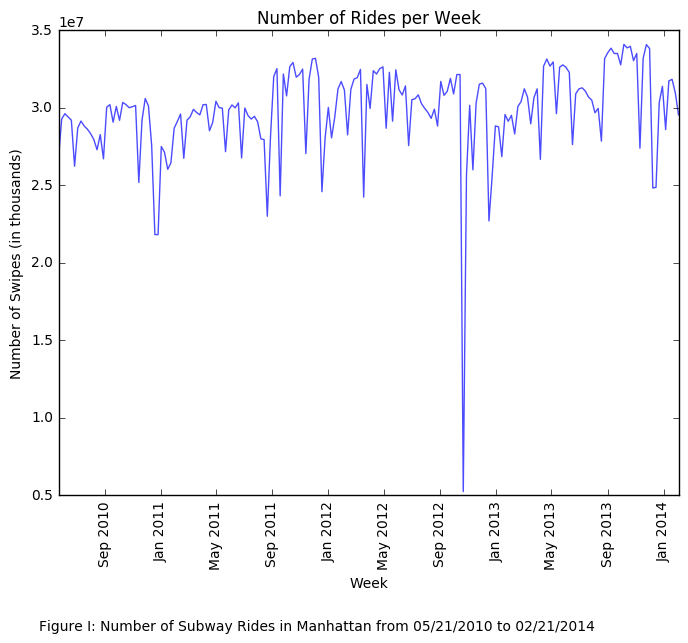

In [37]:
pl.figure(figsize = (8,6))
pl.xlabel("Week")
pl.ylabel("Number of Swipes (in thousands)")

pl.plot(rng, (mtarides_stations_fare),'b', alpha=0.7)
pl.xticks(rotation='90')
pl.legend(loc='upper left')
pl.title("Number of Rides per Week")

figtext(.1,-.1,"Figure I: Number of Subway Rides in Manhattan from 05/21/2010 to 02/21/2014")


In [38]:
#Find the mean and standard deviation and find points that are farther than 3 standard deviations

print ("mean swipes by week {:.2f}".format(np.nanmean(mtarides_stations_fare)))
print ("stdev swipes by week {:.2f}".format(np.nanstd(mtarides_stations_fare)))

thresholds = [np.nanmean(mtarides_stations_fare) + 3 * np.nanstd(mtarides_stations_fare), 
              np.nanmean(mtarides_stations_fare) - 3 * np.nanstd(mtarides_stations_fare)]

print ("3-sigma thresholds {:.2f} {:.2f}".format(*thresholds))

mean swipes by week 29781349.87
stdev swipes by week 2983960.42
3-sigma thresholds 38733231.14 20829468.61


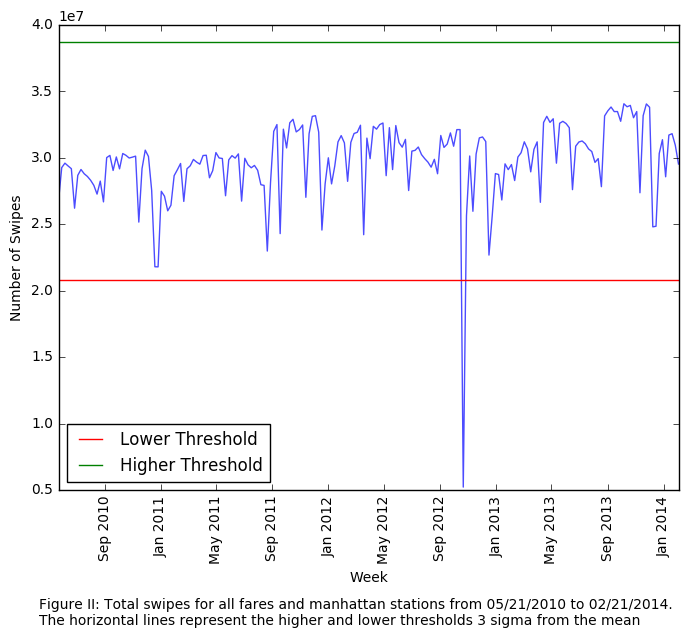

In [39]:
#Plot with the threshholds

pl.figure(figsize=(8, 6))
pl.xlabel("Week")
pl.ylabel("Number of Swipes") 
#pl.ylim(6.5,7.8)

# Plot sum of all rides
pl.plot(rng, (mtarides_stations_fare),'b', alpha=0.7)
pl.xticks(rotation='90')

# Plot the lower Thereshold for the event detection
pl.plot((min(rng), max(rng)),((thresholds[1]),(thresholds[1])), color='r',
       label='Lower Threshold')

# Plot the higher Thereshold for the event detection
pl.plot((min(rng), max(rng)),((thresholds[0]),(thresholds[0])), color='g',
        label='Higher Threshold')

figtext(0.1,-.1,"Figure II: Total swipes for all fares and manhattan stations from 05/21/2010 to 02/21/2014. \n"
 "The horizontal lines represent the higher and lower thresholds 3 sigma from the mean")
pl.legend(loc='lower left')

In [40]:
# Get the date for the event and try to explain what it might be related to
print (rng[np.where(mtarides_stations_fare < thresholds[1])])

DatetimeIndex(['2012-10-21'], dtype='datetime64[ns]', freq=None)


On October 28th, 2012 the NYC Subway closed because of Hurricane Sandy.

# Task 2:
## Identify Fare Types with Steady Trends

In [41]:
#Using mtarides_stations where all stations are summed

#Cycling through the color sequence for the fare types
color_seq = [
    '#FFB300', # Vivid Yellow
    '#803E75', # Strong Purple
    '#FF6800', # Vivid Orange
    '#A6BDD7', # Very Light Blue
    '#C10020', # Vivid Red
    '#CEA262', # Grayish Yellow
    '#817066', # Medium Gray
    # The following don't work well for people with defective color vision
    '#007D34', # Vivid Green
    '#F6768E', # Strong Purplish Pink
    '#00538A', # Strong Blue
    '#FF7A5C', # Strong Yellowish Pink
    '#53377A', # Strong Violet
    '#FF8E00', # Vivid Orange Yellow
    '#B32851', # Strong Purplish Red
    '#F4C800', # Vivid Greenish Yellow
    '#7F180D', # Strong Reddish Brown
    '#93AA00', # Vivid Yellowish Green
    '#593315', # Deep Yellowish Brown
    '#F13A13', # Vivid Reddish Orange
    '#232C16', # Dark Olive Green
    ]

seqlen = len(color_seq)

def plot_ftype(range, ftype, color):
    '''Function to plot the time series cycling through color sequence'''
    pl.plot(range, np.log10(pd.stats.moments.rolling_mean(mtarides_stations[ftype], 10)), color=color, 
           alpha = .7, label = ridetype[ftype])


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:32: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


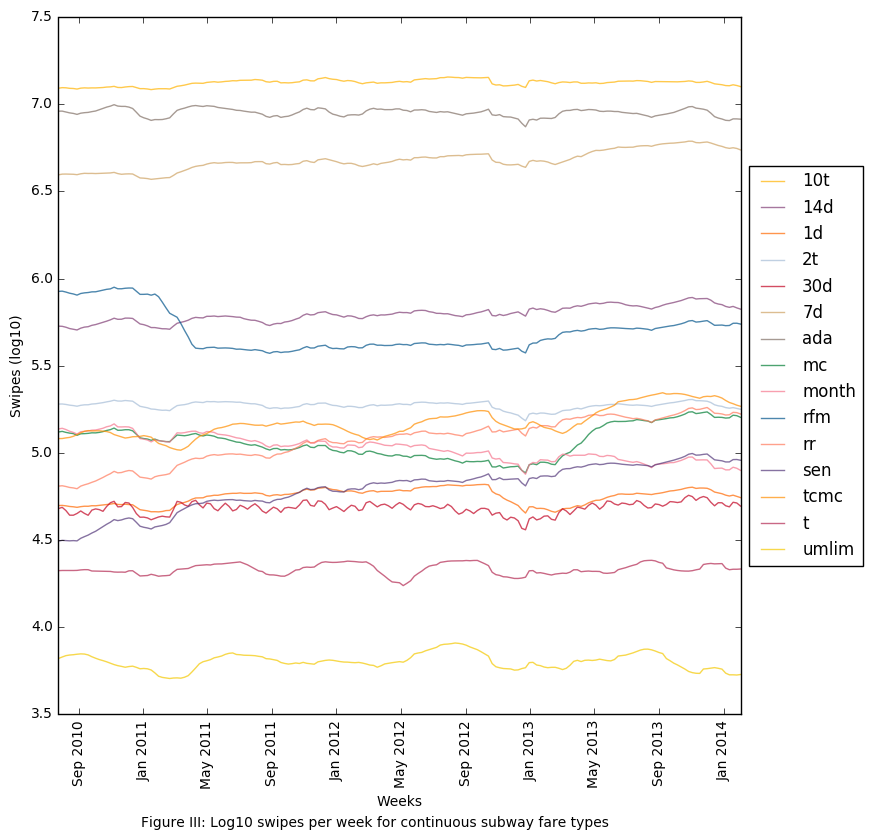

In [42]:
pl.figure(figsize=(11, 9))
pl.xlabel("Weeks")
pl.ylabel("Swipes (log10)") 
ax = plt.subplot(111)
    
curr_col = 0

# Create a dictionary to store the beginnings and ends of the time series
# The key will be the code for the fare type and the values a tuple
# With the position on the original array and the ration value
# E.G. {'2t': (3, 0.933803359955935)}
fareSeriesRatios = {}

for n in range(0,len(mtarides_stations)):
    
    # Check if the time series is continuous (doesnt have weeks with 0 rides)
    # This seems to us a good criteria to rule out upfront things that wont
    # Steaditly increase or decrease
    
    if ((np.min(mtarides_stations[n])) > 0):
        
        
        plot_ftype(rng, n, color_seq[curr_col])
        curr_col = (curr_col + 1)%seqlen
    
        # Sum all the rides for the beginning (first ten weeks)
        # and the end of the series (last ten weeks)
        
        begningSeries = mtarides_stations[n,:10].sum()
        endSeries = mtarides_stations[n,-10:].sum()
        seriesRatio = endSeries/begningSeries
        fareSeriesRatios[ridetype[n]] = (n,seriesRatio)

pl.xticks(rotation='90')

# Shrink current axis by 20%
# So I can put a legend to the right of the current axis
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

figtext(0.2,-.00001,"Figure III: Log10 swipes per week for continuous subway fare types")

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:38: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:35: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


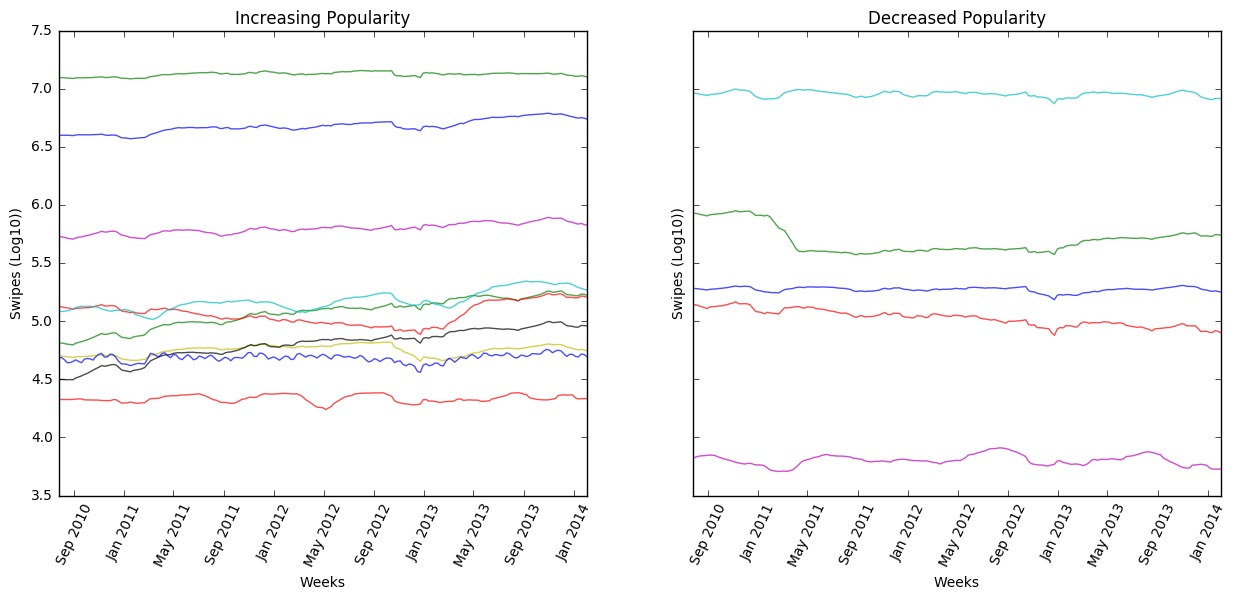

Figure IV: Log10 swipes per week for fares with increasing and decreasing popularity


In [43]:
# If the fare type frequency has increased, the ratio will be > 1 (ended with more rides than started)
# if it decreased, it will be the oposite. Lets plot them

#print (fareSeriesRatios)

#f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
#ax1.set_title('Sharing Y axis')


#for key, value in fareSeriesRatios.iteritems():
#    if (fareSeriesRatios[key][1] > 1):
#        ax1.plot(rng, (pd.stats.moments.rolling_mean(mtarides_stations[fareSeriesRatios[key][0]], 10)), 
 #                alpha = .7, label = key)
  #  else:
   #     ax2.plot(rng, (pd.stats.moments.rolling_mean(mtarides_stations[fareSeriesRatios[key][0]], 10)), 
    #             alpha = .7, label = key)
        

# If a ridership type popularity has increased, the ratio will be > 1 (ended with more rides that started)
# if it decreased, it will be the oposite. Lets plot them side by side

f, (ax1, ax2) = pl.subplots(1, 2, sharey=True, figsize=(15,6))

for ax in f.axes:
    matplotlib.pyplot.sca(ax)
    plt.xticks(rotation='65')
    pl.xlabel("Weeks")
    pl.ylabel("Swipes (Log10))") 
      
ax1.set_title('Increasing Popularity')
ax2.set_title('Decreased Popularity')

for key, value in fareSeriesRatios.iteritems():
    if (fareSeriesRatios[key][1] > 1):
        ax1.plot(rng, np.log10(pd.stats.moments.rolling_mean(mtarides_stations[fareSeriesRatios[key][0]], 10)), 
                 alpha = .7, label = key)
    else:
        ax2.plot(rng, np.log10(pd.stats.moments.rolling_mean(mtarides_stations[fareSeriesRatios[key][0]], 10)), 
                 alpha = .7, label = key)

pl.show()


print ("Figure IV: Log10 swipes per week for fares with increasing and decreasing popularity")

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:21: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:24: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


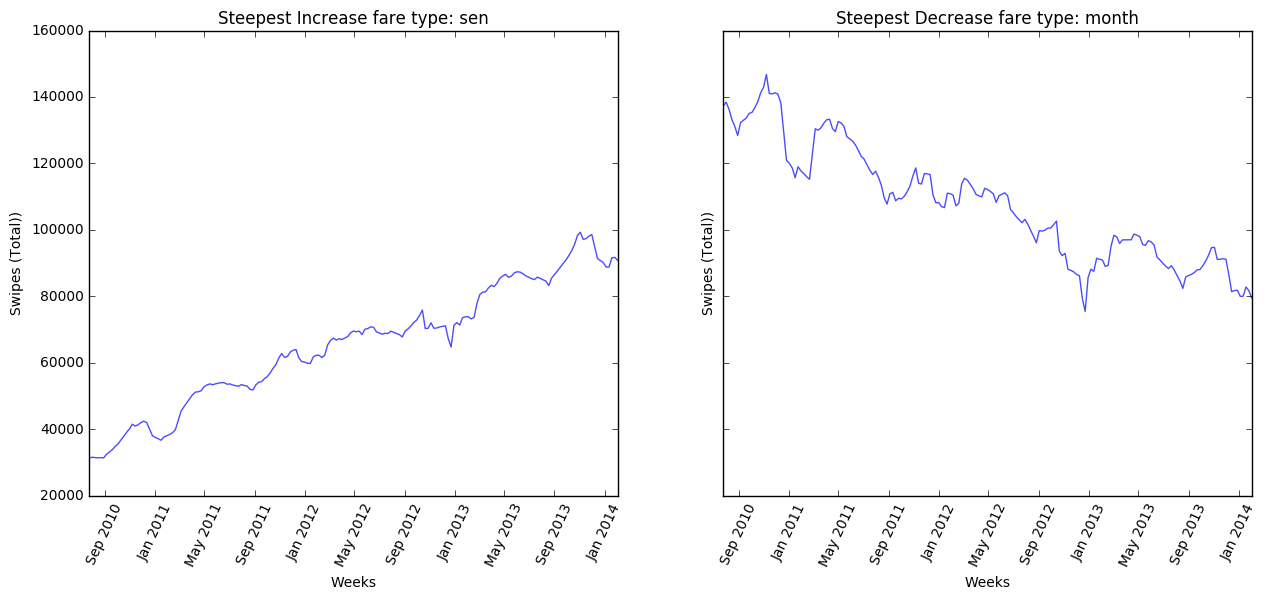

Figure V: Total swipes per week for the steepest increase and decres fares

The fare type with the steepest upware trend is sen, this fare went from an average 
of 31208.6 swipes per week during the first 10 weeks to an average of 90798.2 during the last ten weeks


The fare type with the steepest downard trend is month, this fare went from an average 
of 137296.4 swipes per week during the first 10 weeks to an average of 79456.5 during the last ten weeks


In [67]:
# Getting the min and max values from the fareSeriesRations dictionary
# This will represent the fares with the steepest upward and dowward trends
# Snippet to Get max and min from a dic from stack overflow (http://stackoverflow.com/a/3282871)

downFare =  min(fareSeriesRatios.items(), key=lambda x: x[1][1])
upFare =  max(fareSeriesRatios.items(), key=lambda x: x[1][1])

# Plot both side by side, using absolute values (not log10) with rolling mean for 10 weeks

f, (ax1, ax2) = pl.subplots(1, 2, sharey=True,figsize=(15,6))

for ax in f.axes:
    matplotlib.pyplot.sca(ax)
    pl.xticks(rotation='65')
    pl.xlabel("Weeks")
    pl.ylabel("Swipes (Total))") 

ax1.set_title('Steepest Increase fare type: ' + upFare[0])
ax2.set_title('Steepest Decrease fare type: ' + downFare[0])

ax1.plot(rng, pd.stats.moments.rolling_mean(mtarides_stations[fareSeriesRatios['sen'][0]],10)
         , alpha = .7, label = 'sen')

ax2.plot(rng, pd.stats.moments.rolling_mean(mtarides_stations[fareSeriesRatios['month'][0]],10)
        , alpha = .7, label = 'month')

pl.show()

print ("Figure V: Total swipes per week for the steepest increase and decres fares" + '\n')

print ("The fare type with the steepest upware trend is " + upFare[0] + ", this fare went from an average " +
       '\n' + "of " + str(np.average(mtarides_stations[ridetype.index(upFare[0])][:10])) + " swipes " +
       "per week during the first 10 weeks to an average of " 
       + str(np.average(mtarides_stations[ridetype.index(upFare[0])][-10:])) + " during the last ten weeks")

print ('\n')

print ("The fare type with the steepest downard trend is " + downFare[0] + ", this fare went from an average " +
       '\n' + "of " + str(np.average(mtarides_stations[ridetype.index(downFare[0])][:10])) + " swipes " +
       "per week during the first 10 weeks to an average of " 
       + str(np.average(mtarides_stations[ridetype.index(downFare[0])][-10:])) + " during the last ten weeks")


# Analysis 3: Trend Analysis
## The third part of the analysis will attempt to identify the four stations that show the most prominent periodic trend on an anual period. We will attempt to explain the reason for this periodic peak

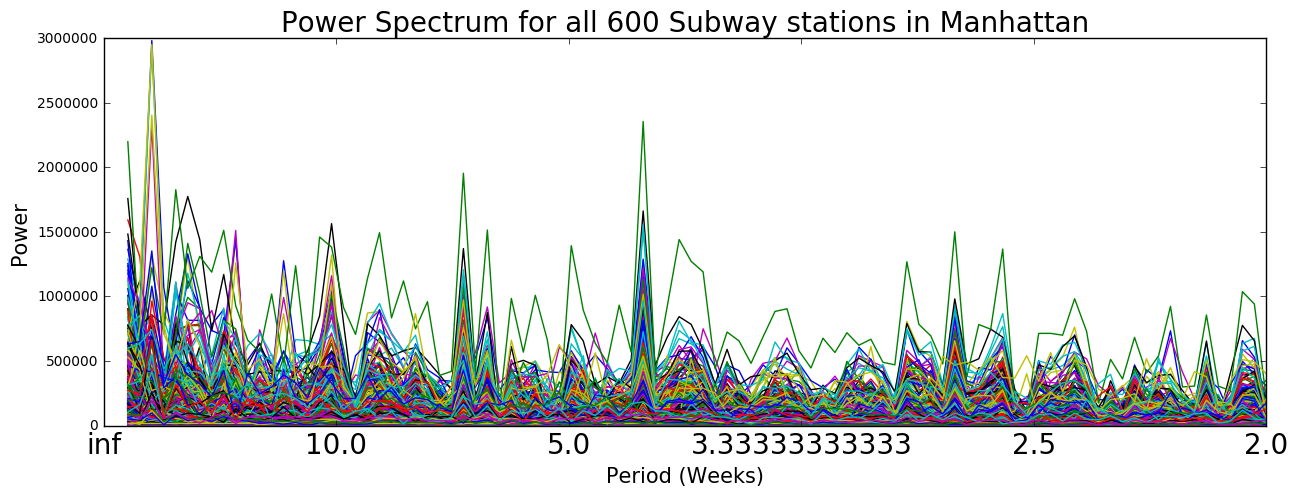

In [69]:
# Will collapse the fare types dimension of the cube (we care about stations here!)
mtarides_stations = np.nansum(mtarides, axis=1)

# Will visually inspect all the stations plotting their power spectrum, excluding the first two elements on the X
# (Frequencies that correspond Infinity and the whole period: "Uninteresting")
# as explained in https://github.com/fedhere/UInotebooks/blob/master/timeseries/fourier.ipynb

N = len(mtarides_stations[1])
fig=pl.figure(figsize=(15,5))
ax=fig.add_subplot(111)

# Create a dictionary to store the frequency bin centers in cycles per week (X Axis)
# and the Fourier Transform value (Y) for eac of the stations

mtarides_stations_yearPeriodicity = {}
mtarides_stations_power = {}
for i in range (len(mtarides_stations)):
    f = np.abs(np.fft.rfft(mtarides_stations[i]))
    ffreq = np.fft.rfftfreq(N, 1.0)
    mtarides_stations_power[i]=(ffreq,f)
    ax.plot(ffreq[2:], (f[2:]), '-')
    mtarides_stations_yearPeriodicity[i]=((f[4]))

ax.set_xticklabels([ "%s"%(1/f) for f in ax.get_xticks()], fontsize=20)
pl.xlabel("Period (Weeks)", fontsize=15)
pl.ylabel("Power", fontsize=15)

ax.set_title('Power Spectrum for all 600 Subway stations in Manhattan', fontsize=20)

#### Figure VI: This plot is the power spectrum of the 600 stations. We will focus on the initial positions of the array, but we see from this graph that there might be other interesting periodicities.

In [70]:
# Explore the frequency bins

print ("Center of the bin 3: " + str(1 / ffreq [3]) + ' Weeks')
print ("Center of the bin 4: " + str(1 / ffreq [4]) + ' Weeks')
print ("Center of the bin 5: " + str(1 / ffreq [5]) + ' Weeks')

Center of the bin 3: 64.6666666667 Weeks
Center of the bin 4: 48.5 Weeks
Center of the bin 5: 38.8 Weeks


In [72]:
# The fourth position of the array (1 / 48.5 weeks) is the closest (year is aprox 52.1429 weks)
# Lets get the stations with the higher values for this bin
# Will use collections.counter, code snippet from
# http://stackoverflow.com/questions/11902665/top-values-from-dictionary

d = collections.Counter(mtarides_stations_yearPeriodicity)
most_yearly_periodic_stations = []

for k, v in d.most_common(4):
    most_yearly_periodic_stations.append(k)

print ("The most yearly period stations are: " + str (most_yearly_periodic_stations))

The most yearly period stations are: [0, 194, 150, 327]


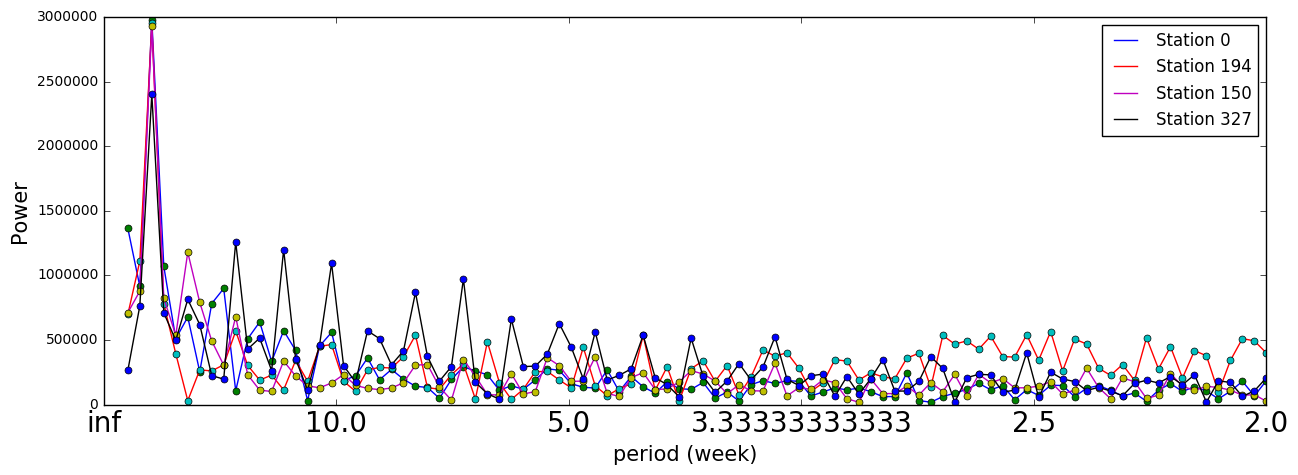

In [76]:
# Visualize the power spectrum only for those four stations (cleaner chart!)

N = len(mtarides_stations[1])
fig=pl.figure(figsize=(15,5))
ax=fig.add_subplot(111)
pl.xlabel("period (week)", fontsize=15)
pl.ylabel("Power", fontsize=15)


for i in range(len(most_yearly_periodic_stations)):
    f = np.abs(np.fft.rfft(mtarides_stations[most_yearly_periodic_stations[i]]))
    ffreq = np.fft.rfftfreq(N, 1.0)
    mtarides_stations_power[i]=(ffreq,f)
    ax.plot(ffreq[2:], (f[2:]), '-', label="Station " + str(most_yearly_periodic_stations[i]))
    ax.plot(ffreq[2:], (f[2:]), 'o', ms=5)
    mtarides_stations_yearPeriodicity[i]=((f[4]))

ax.legend(loc='best', fontsize=12)
ax.set_xticklabels([ "%s"%(1/f) for f in ax.get_xticks()], fontsize=20)

#### Figure VII: This plot reflects the power spectrum of the four stations with the most periodicity

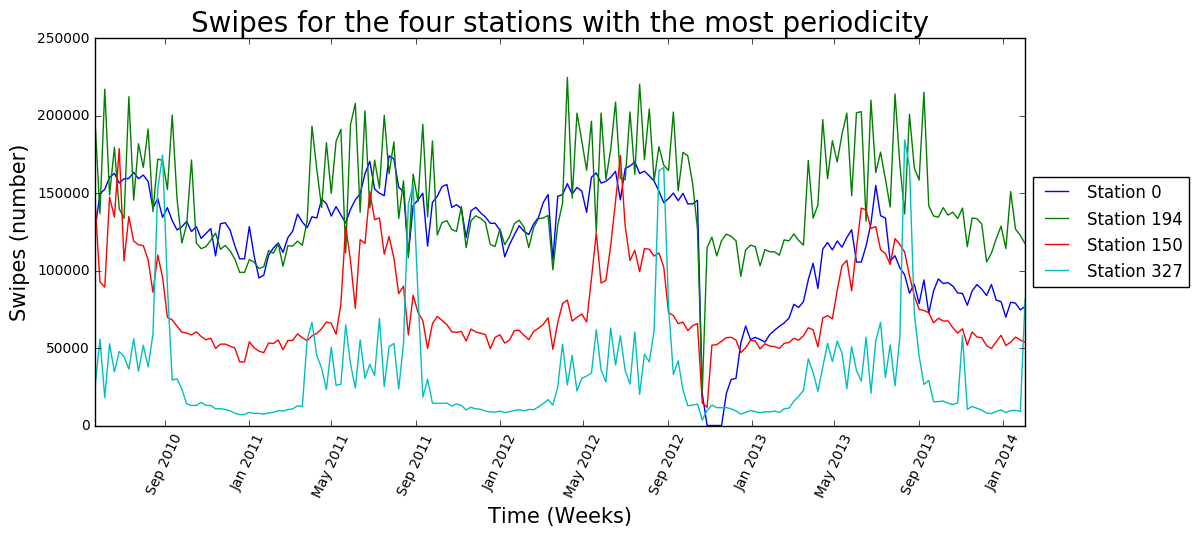

In [79]:
# Plotting the station swipes and dates to try to find possible events that explain the preiodicity

fig=pl.figure(figsize=(15,5))
ax=fig.add_subplot(111)
pl.xlabel("Time (Weeks)", fontsize=15)
pl.ylabel("Swipes (number)", fontsize=15)
ax.legend(loc='best', fontsize=12)
pl.title("Swipes for the four stations with the most periodicity", fontsize=20)
pl.xticks(rotation='65')

for i in range(len(most_yearly_periodic_stations)):
    ax.plot(rng, mtarides_stations[most_yearly_periodic_stations[i]], 
            '-', label="Station " + str(most_yearly_periodic_stations[i]))
    
# Shrink current axis by 20%
# So I can put a legend to the right of the current axis
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#### The four stations with the most periodicity are stations 0, 150, 194 , and 327.